In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import rtree, pygeos, fiona
# import netCDF4
# import xarray as xr
# import dask

/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import re
# import pyproj

In [3]:
from import_functions import readin_and_subset_modis, get_folder_contents, get_modis_filedata
from modis_cleaning import clean_modis, add_consec_months_by_year, aggregate_by_county
from constants import REPO_PATH, DATA_PATH, DATA_CLEAN_PATH
from constants import GEO_CRS, PROJ_CRS
from constants import set_plt_settings

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

In [4]:
set_plt_settings()

# read in county shapefiles

In [5]:
c_filepath = str(DATA_PATH / 'county_shapefiles/cb_2018_us_county_5m.shp')
counties = gpd.read_file(c_filepath).to_crs(GEO_CRS)
counties.columns = counties.columns.str.lower()

# read and clean modis

In [6]:
folders = ('lst', 'ndvi')
prop_strs = ('LST_Day_CMG', 'CMG 0.05 Deg Monthly NDVI')
# i = 1
# folder = folders[i]
# prop_str = prop_strs[i]

In [7]:
# loop through modis datasets
modis = pd.DataFrame()
dfs = {}
for folder, prop_str in zip(folders, prop_strs):
    print(f'====== {folder} =====')
    folderpath = DATA_PATH / folder

    # read and clean
    print('reading and cleaning...')
    df_raw, failed_loads = readin_and_subset_modis(folderpath=folderpath, prop_str=prop_str)
    print(f'failed to load {len(failed_loads)} files: {failed_loads}')
    df = clean_modis(df_raw)
    df = add_consec_months_by_year(df, 'prop', 'mean', ['lat', 'lon'], 'year')

    # collapse to annual
    print('collapsing to annual data...')
    df_a = (df
         .groupby(['lat', 'lon', 'year'])[['prop', 'mbm', 'dbm', 'consec_mbm']]
         .agg({'prop':['mean','std', 'min', 'max'], 'mbm':'sum', 'dbm':'sum', 'consec_mbm':'max'}))
    df_a.columns = ['_'.join(col).strip() for col in df_a.columns.values]
    df_a = df_a.reset_index()

    # collapse by county
    print('collapsing to county-level data...')
    df_ac = aggregate_by_county(df_a, counties)
    df_ac['value'] = folder

    # stack
    dfs[folder] = (df, df_a, df_ac)
    modis = pd.concat([df_ac, modis])

====== lst =====
reading and cleaning...
files to read: 263


100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


failed to load 0 files: []
Outlier threshold: [44340.]
Outliers dropped: 0 (0.00%)
collapsing to annual data...
collapsing to county-level data...
====== ndvi =====
reading and cleaning...
files to read: 263


100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


failed to load 0 files: []
Outlier threshold: [10158.]
Outliers dropped: 0 (0.00%)
collapsing to annual data...
collapsing to county-level data...


# Write data to computer

In [9]:
filename = 'modis_cln.csv'
filepath = DATA_CLEAN_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
modis.to_csv(filepath, index=False)

# Visualize

In [14]:
prop = 'lst'
year = 2000
title = f'MODIS: Land surface temperature, {year}'
prop = 'prop_mean'

vdf = dfs[prop][1]
vdf = vdf.loc[vdf.year == year]

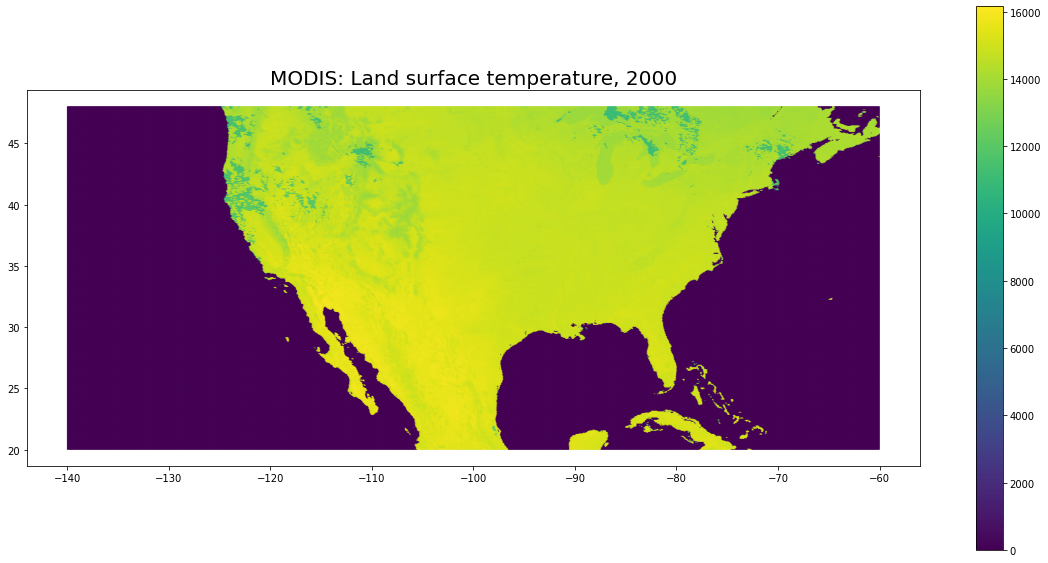

In [16]:
# Visualize
geometry = [Point(xy) for xy in zip(vdf['lon'], vdf['lat'])]
gp = gpd.GeoDataFrame(vdf, crs=GEO_CRS, geometry=geometry)
fig,ax = plt.subplots(figsize=(20,10))
gp.plot(ax=ax, column=prop, markersize=0.1, legend=True)
plt.title(title)
plt.show()